# Development Sandbox

## Preliminary

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from os import path
import matplotlib.pyplot as plt
import numpy as np
import numpy.testing as npt
import PIL.Image as Image
import sys
import tensorflow as tf

sys.path.append("..")
sys.path.append("../utils")

from tflego import blocks
from tflego import training
from tflego.blocks import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE
import plotting

In [3]:
output_dir = "/tmp/data/"

## Load MNIST data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(output_dir, one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


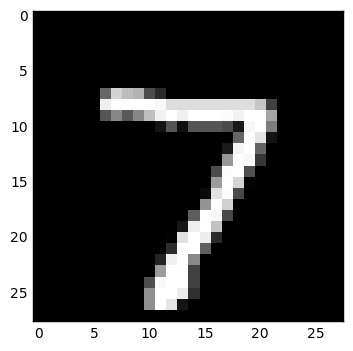

In [5]:
plt.imshow(np.reshape(mnist.test.images[0, :], (28, 28)), cmap="Greys_r", interpolation="nearest")

## Sequence-to-sequence

In [11]:
tf.reset_default_graph()

# Random seed
np.random.seed(1)
tf.set_random_seed(1)

# Test data
n_input = 3
n_data = 4
n_maxlength = 5
test_data = np.zeros((n_data, n_maxlength, n_input), dtype=NP_DTYPE)
lengths = []
for i_data in xrange(n_data):
    length = np.random.randint(1, n_maxlength + 1)
    lengths.append(length)
    test_data[i_data, :length, :] = np.random.randn(length, n_input)
lengths = np.array(lengths, dtype=NP_ITYPE)

# Model parameters
n_hidden = 6
rnn_type = "rnn"

# TensorFlow model
x = tf.placeholder(TF_DTYPE, [None, n_maxlength, n_input])
x_lengths = tf.placeholder(TF_DTYPE, [None])
rnn_outputs, rnn_states = blocks.build_rnn(x, x_lengths, n_hidden, rnn_type=rnn_type)

print [v.name for v in tf.all_variables()]
with tf.variable_scope("RNN/BasicRNNCell/Linear", reuse=True):
    W = tf.get_variable("Matrix")
    b = tf.get_variable("Bias")

# TensorFlow graph
init = tf.initialize_all_variables()
with tf.Session() as session:
    session.run(init)

    # Output
    tf_output = rnn_outputs.eval({x: test_data, x_lengths: lengths})
    tf_states = rnn_states.eval({x: test_data, x_lengths: lengths})

    # Weights
    W = W.eval()
    b = b.eval()

# Numpy model
# np_output = np_rnn(test_data, lengths, W, b, n_maxlength)


# npt.assert_almost_equal(tf_output, np_output, decimal=5)

[u'RNN/BasicRNNCell/Linear/Matrix:0', u'RNN/BasicRNNCell/Linear/Bias:0']


In [100]:
np.random.seed(1)
b = ["asd", "ddd", "c"]
np.random.shuffle(b)
print b

['asd', 'c', 'ddd']


In [85]:
tf.reset_default_graph()

# Random seed
np.random.seed(1)
# tf.set_random_seed(1)

# Test data
n_input = 3
n_data = 4
n_maxlength = 5
test_data = np.zeros((n_data, n_maxlength, n_input), dtype=NP_DTYPE)
lengths = []
for i_data in xrange(n_data):
    length = np.random.randint(1, n_maxlength + 1)
    lengths.append(length)
    test_data[i_data, :length, :] = np.random.randn(length, n_input)
lengths = np.array(lengths, dtype=NP_ITYPE)

# Model parameters
n_hidden = 6
n_output = n_input
rnn_type = "rnn"

# TensorFlow model
x = tf.placeholder(TF_DTYPE, [None, n_maxlength, n_input])
x_lengths = tf.placeholder(TF_DTYPE, [None])
rnn_outputs, rnn_states = blocks.build_rnn(x, x_lengths, n_hidden, rnn_type=rnn_type, scope="rnn_encoder")
print "!"*5, rnn_outputs
print rnn_outputs.name

def unpack_sequence(tensor):
    """Split the single tensor of a sequence into a list of frames."""
    return tf.unpack(tf.transpose(tensor, perm=[1, 0, 2]))

def pack_sequence(sequence):
    """Combine a list of the frames into a single tensor of the sequence."""
    return tf.transpose(tf.pack(sequence), perm=[1, 0, 2])


def build_encdec_lazydynamic():
    pass


def build_encdec_outback():
    pass




def build_rnn_decoder_outback(initial_state, n_hidden, n_output, maxlength,
        rnn_type="lstm", initial_prev_output=None, dtype=None, **kwargs):
    """In this decoder the output is fed back as input."""

    with tf.variable_scope("rnn_decoder") as scope:
    
        # RNN decoder cell
        cell = blocks.build_rnn_cell(n_hidden, rnn_type, **kwargs)

        # Initial state and input
        state = initial_state
        if rnn_type == "lstm":
            batch_size = tf.shape(initial_state[0])[0]  # cell and hidden states together in tuple
        elif rnn_type == "gru" or rnn_type == "rnn":
            batch_size = tf.shape(initial_state)[0]
        if initial_prev_output is not None:
            prev_output = initial_prev_output
        else:
            if not dtype:
                raise ValueError("If no initial_prev_output is provided, dtype must be.")
            prev_output = tf.zeros([batch_size, n_output], dtype)
            prev_output.set_shape([None, n_output])
            print prev_output
        
        # Decode over timesteps
        outputs = []
        for i_time in xrange(maxlength):
            if i_time > 0:
                scope.reuse_variables()
            output, state = cell(prev_output, state)
            with tf.variable_scope("linear_output"):
                output = blocks.build_linear(output, n_output)
            outputs.append(output)
            prev_output = output

        return pack_sequence(outputs)

# print "4", rnn_states
#     rnn_states = rnn_states
rnn_decoder = build_rnn_decoder_outback(rnn_states, n_hidden, n_output, n_maxlength, rnn_type, dtype=TF_DTYPE)


#     for i_time in xrange(max_length):
        
        
#         if i > 0:
#             variable_scope.get_variable_scope().reuse_variables()
            


with tf.variable_scope("rnn_encoder/BasicRNNCell/Linear", reuse=True):
    W = tf.get_variable("Matrix")
    b = tf.get_variable("Bias")
with tf.variable_scope("rnn_decoder/BasicRNNCell/Linear", reuse=True):
    W_rnn_decoder = tf.get_variable("Matrix")
    b_rnn_decoder = tf.get_variable("Bias")
with tf.variable_scope("rnn_decoder/linear_output", reuse=True):
    W_rnn_output = tf.get_variable("W")
    b_rnn_output = tf.get_variable("b")

    
# TensorFlow graph
init = tf.initialize_all_variables()
with tf.Session() as session:
    session.run(init)

    # Output
    tf_output = rnn_outputs.eval({x: test_data, x_lengths: lengths})
#     tf_states = rnn_states.eval({x: test_data, x_lengths: lengths})
    tf_decoder = rnn_decoder.eval({x: test_data, x_lengths: lengths})

    # Weights
    W = W.eval()
    b = b.eval()
    W_rnn_decoder = W_rnn_decoder.eval()
    b_rnn_decoder = b_rnn_decoder.eval()
    W_rnn_output = W_rnn_output.eval()
    b_rnn_output = b_rnn_output.eval()

# # Numpy model
np_output = blocks.np_rnn(test_data, lengths, W, b, n_maxlength)

def np_rnn_decoder_outback(initial_states, W_hidden, b_hidden, W_output,
        b_output, max_length):
    """
    In this decoder the output is fed back as input.
    
    Parameters
    ----------
    initial_hiddens : matrix [batch_size, n_hidden]
    """
    outputs = []
    for i_data in xrange(initial_states.shape[0]):
        output = []
        prev_output = np.zeros(W_output.shape[1])
        prev_state = initial_states[i_data]
        for i_time in xrange(max_length):
            cur_state = np.tanh(np.dot(np.hstack((prev_output, prev_state)), W_hidden) + b_hidden)
            cur_output = np.dot(cur_state, W_output) + b_output
            prev_state = cur_state
            prev_output = cur_output
            output.append(cur_output)
        outputs.append(output)
    return np.array(outputs)

initial_state = []
for i_data, l in enumerate(lengths):
    initial_state.append(np_output[i_data, l - 1, :])
initial_state = np.array(initial_state)
        
np_decoder = np_rnn_decoder_outback(
    initial_state, W_rnn_decoder, b_rnn_decoder, W_rnn_output, b_rnn_output, n_maxlength
    )

print tf_output.shape
print tf_states.shape
print tf_decoder.shape
print test_data.shape

print [v.name for v in tf.all_variables()]

npt.assert_almost_equal(tf_output, np_output, decimal=5)
npt.assert_almost_equal(tf_decoder, np_decoder, decimal=5)


!!!!! Tensor("rnn_encoder/transpose:0", shape=(?, 5, 6), dtype=float32)
rnn_encoder/transpose:0
Tensor("rnn_decoder/zeros:0", shape=(?, 3), dtype=float32)
(4, 5, 6)
(4, 6)
(4, 5, 3)
(4, 5, 3)
[u'rnn_encoder/BasicRNNCell/Linear/Matrix:0', u'rnn_encoder/BasicRNNCell/Linear/Bias:0', u'rnn_decoder/BasicRNNCell/Linear/Matrix:0', u'rnn_decoder/BasicRNNCell/Linear/Bias:0', u'rnn_decoder/linear_output/W:0', u'rnn_decoder/linear_output/b:0']


In [87]:
x.get_shape().as_list()

[None, 5, 3]

In [54]:
tf.reset_default_graph()

# Random seed
np.random.seed(1)
# tf.set_random_seed(1)

# Test data
n_input = 3
n_data = 4
n_maxlength = 5
test_data = np.zeros((n_data, n_maxlength, n_input), dtype=NP_DTYPE)
lengths = []
for i_data in xrange(n_data):
    length = np.random.randint(1, n_maxlength + 1)
    lengths.append(length)
    test_data[i_data, :length, :] = np.random.randn(length, n_input)
lengths = np.array(lengths, dtype=NP_ITYPE)

# Model parameters
n_hidden = 6
n_output = n_input
rnn_type = "rnn"

# TensorFlow model
x = tf.placeholder(TF_DTYPE, [None, n_maxlength, n_input])
x_lengths = tf.placeholder(TF_DTYPE, [None])
rnn_outputs, rnn_states = blocks.build_rnn(x, x_lengths, n_hidden, rnn_type=rnn_type, scope="rnn_encoder")
rnn_repeat_states = tf.reshape(tf.tile(rnn_states, [1, n_maxlength]), [-1, n_maxlength, n_hidden])
rnn_decoder_outputs, rnn_decoder_states = blocks.build_rnn(rnn_repeat_states, x_lengths, n_hidden, rnn_type=rnn_type, scope="rnn_decoder")
with tf.variable_scope("rnn_decoder"):
    with tf.variable_scope("linear_output"):
        rnn_decoder_outputs = tf.reshape(rnn_decoder_outputs, [-1, n_hidden])
        rnn_decoder_outputs = blocks.build_linear(rnn_decoder_outputs, n_output)
        rnn_decoder_outputs = tf.reshape(rnn_decoder_outputs, [-1, n_maxlength, n_output])

with tf.variable_scope("rnn_encoder/BasicRNNCell/Linear", reuse=True):
    W = tf.get_variable("Matrix")
    b = tf.get_variable("Bias")
with tf.variable_scope("rnn_decoder/BasicRNNCell/Linear", reuse=True):
    W_rnn_decoder = tf.get_variable("Matrix")
    b_rnn_decoder = tf.get_variable("Bias")
with tf.variable_scope("rnn_decoder/linear_output", reuse=True):
    W_rnn_output = tf.get_variable("W")
    b_rnn_output = tf.get_variable("b")

# TensorFlow graph
init = tf.initialize_all_variables()
with tf.Session() as session:
    session.run(init)

    # Output
    tf_encoder = rnn_outputs.eval({x: test_data, x_lengths: lengths})
    tf_states = rnn_states.eval({x: test_data, x_lengths: lengths})
    rnn_repeat_states = rnn_repeat_states.eval({x: test_data, x_lengths: lengths})
    rnn_decoder_outputs = rnn_decoder_outputs.eval({x: test_data, x_lengths: lengths})

    # Weights
    W_rnn_encoder = W.eval()
    b_rnn_encoder = b.eval()
    W_rnn_decoder = W_rnn_decoder.eval()
    b_rnn_decoder = b_rnn_decoder.eval()
    W_rnn_output = W_rnn_output.eval()
    b_rnn_output = b_rnn_output.eval()    
    
print test_data.shape
print tf_encoder.shape
print tf_states.shape
# print tf_states
# print rnn_repeat_states.shape
# print rnn_repeat_states
# print tf_states
print rnn_decoder_outputs.shape


(4, 5, 3)
(4, 5, 6)
(4, 6)
(4, 5, 3)


In [83]:
np_encoder = blocks.np_rnn(test_data, lengths, W_rnn_encoder, b_rnn_encoder, n_maxlength)

rnn_states = []
for i_data, l in enumerate(lengths):
    rnn_states.append(np_encoder[i_data, l - 1, :])
rnn_states = np.array(rnn_states)

np_states_repeated = np.reshape(np.repeat(rnn_states, n_maxlength, axis=0), [-1, n_maxlength, n_hidden])
np_decoder = blocks.np_rnn(np_states_repeated, lengths, W_rnn_decoder, b_rnn_decoder, n_maxlength)

x = np_decoder
x_lengths = lengths
maxlength = n_maxlength
outputs = np.zeros((x.shape[0], maxlength, n_output))
for i_data in xrange(x.shape[0]):
    cur_x_sequence = x[i_data, :, :]
    for i_step, cur_x in enumerate(cur_x_sequence):
#         print cur_x
        outputs[i_data, i_step, :] = blocks.np_linear(cur_x, W_rnn_output, b_rnn_output)
#     break

# print np_encoder
# print rnn_states
# print np_decoder


# print rnn_decoder_outputs
# print outputs

npt.assert_almost_equal(outputs, rnn_decoder_outputs, decimal=5)

In [90]:
W_rnn_encoder.shape

(9, 6)

In [89]:
n_hidden

6